In [14]:
excel_path = "/Users/sherryyang/Documents/wiggins-lab/data/manually_linked.xlsx"
import pandas as pd

excel_file = pd.ExcelFile(excel_path)
sheet_names = excel_file.sheet_names

manual_link_master_dict = {}
for time_sheet in sheet_names:
        df = excel_file.parse(time_sheet)
        df = df.astype(str)
        columns = df.columns
        
        time_dict = {}
        for index, row in df.iterrows():
            try:
                mother = int(row[columns[0]])
            except ValueError:
                mother = None
            daughter = row[columns[1]].lower()
            if 'x' in daughter:
                cell_list = []
            else:
                cell_list = daughter.split(',')
            time_dict[mother] = {int(x) for x in cell_list}
        
        manual_link_master_dict[time_sheet] = time_dict

In [27]:
import pandas as pd
from scipy.io import savemat
import numpy as np
import glob
import os
import re
from scipy.io import loadmat


def make_cell_info_reference(labels_mask):
    
    label_info_df = pd.DataFrame(columns = ['label', 'x_mean', 'y_mean', 'area'])
    regs_label = labels_mask

    for i in range(1,np.max(regs_label)+1):
        row_indices, col_indices = np.where(regs_label == i)
        if len(row_indices) > 0:
            new_row = {'label': i, 'x_mean': np.average(col_indices), 'y_mean': np.average(row_indices), 'area': len(row_indices)}
            label_info_df.loc[len(label_info_df)] = new_row

    return label_info_df


def get_supersegger_file_info_and_tracker_result(foldername):
    npzFiles = glob.glob(foldername)
    cell_info_dict = {}
    supperSegger_dict = {}

    for f in npzFiles:
        pattern = r'_t(\d+)'
        match = re.search(pattern, f)

        if match:
            t_value = match.group(1)
            frame_index = 't' + t_value
        else:
            raise ValueError('No time index on filename.')
        
        data = loadmat(f)
        label = data['regs']['regs_label'][0][0]
        track_result = data['regs']['map'][0][0]['f'][0][0][0]

        superSegger_final_tracker = {}
        for i in range(len(track_result)):
            superSegger_final_tracker[i+1] = set(track_result[i][0])

        cell_info_dict[frame_index] = make_cell_info_reference(label)
        supperSegger_dict[frame_index] = superSegger_final_tracker

    return cell_info_dict, supperSegger_dict


In [28]:
cell_info_dict, supperSegger_dict = get_supersegger_file_info_and_tracker_result("/Users/sherryyang/Documents/wiggins-lab/data/0820/xy0/seg/*err.mat")

In [16]:
different_tracker_matches = pd.read_csv('/Users/sherryyang/Documents/wiggins-lab/data/trackers_matchs_index.csv')

In [41]:
tracks = pd.read_csv('/Users/sherryyang/Documents/wiggins-lab/data/track.csv', header=[0, 1, 2, 3])
spots = pd.read_csv('/Users/sherryyang/Documents/wiggins-lab/data/spots.csv', header=[0, 1, 2, 3])

time = spots.columns[8]
x_position = spots.columns[4]
y_position = spots.columns[5]


area = spots.columns[26]

label_correlated_dic = {}

for index, row in spots.iterrows():
    #Trackmate using timeframe start from 0
    time_index = row[time] + 1
    formatted_int_str = f"{time_index:05d}"
    time_str_with_prefix = f't{formatted_int_str}'
    df = cell_info_dict[time_str_with_prefix]

    trackmate_x = row[x_position]*100
    trackmate_y = row[y_position]*100
    trackmate_area = row[area] * 10000

    candidate = df.loc[(abs(df['x_mean'] - trackmate_x) < 1.5) & (abs(df['y_mean'] - trackmate_y) < 1.5) & (abs(df['area'] - trackmate_area) < 50)]
    if len(candidate) == 0 or len(candidate) > 1:
        raise ValueError('Not 1:1 relationship')
    
    label_correlated_dic[row[spots.columns[1]]] =  candidate.iloc[0]['label']

ValueError: Not 1:1 relationship

In [49]:
time_str_with_prefix 

't00004'

In [43]:
trackmate_x

2095.3248374711366

In [44]:
trackmate_y

1633.858377660042

In [46]:
trackmate_area

2256.000000000006

In [47]:
row

LABEL                 Label                   Label          Unnamed: 0_level_3           ID2312
ID                    Spot ID                 Spot ID        Unnamed: 1_level_3             2312
TRACK_ID              Track ID                Track ID       Unnamed: 2_level_3             20.0
QUALITY               Quality                 Quality        (quality)                    2239.0
POSITION_X            X                       X              ( )                       20.953248
POSITION_Y            Y                       Y              ( )                       16.338584
POSITION_Z            Z                       Z              ( )                             0.0
POSITION_T            T                       T              (frame)                         3.0
FRAME                 Frame                   Frame          Unnamed: 8_level_3                3
RADIUS                Radius                  R              ( )                        0.267975
VISIBILITY            Visibili

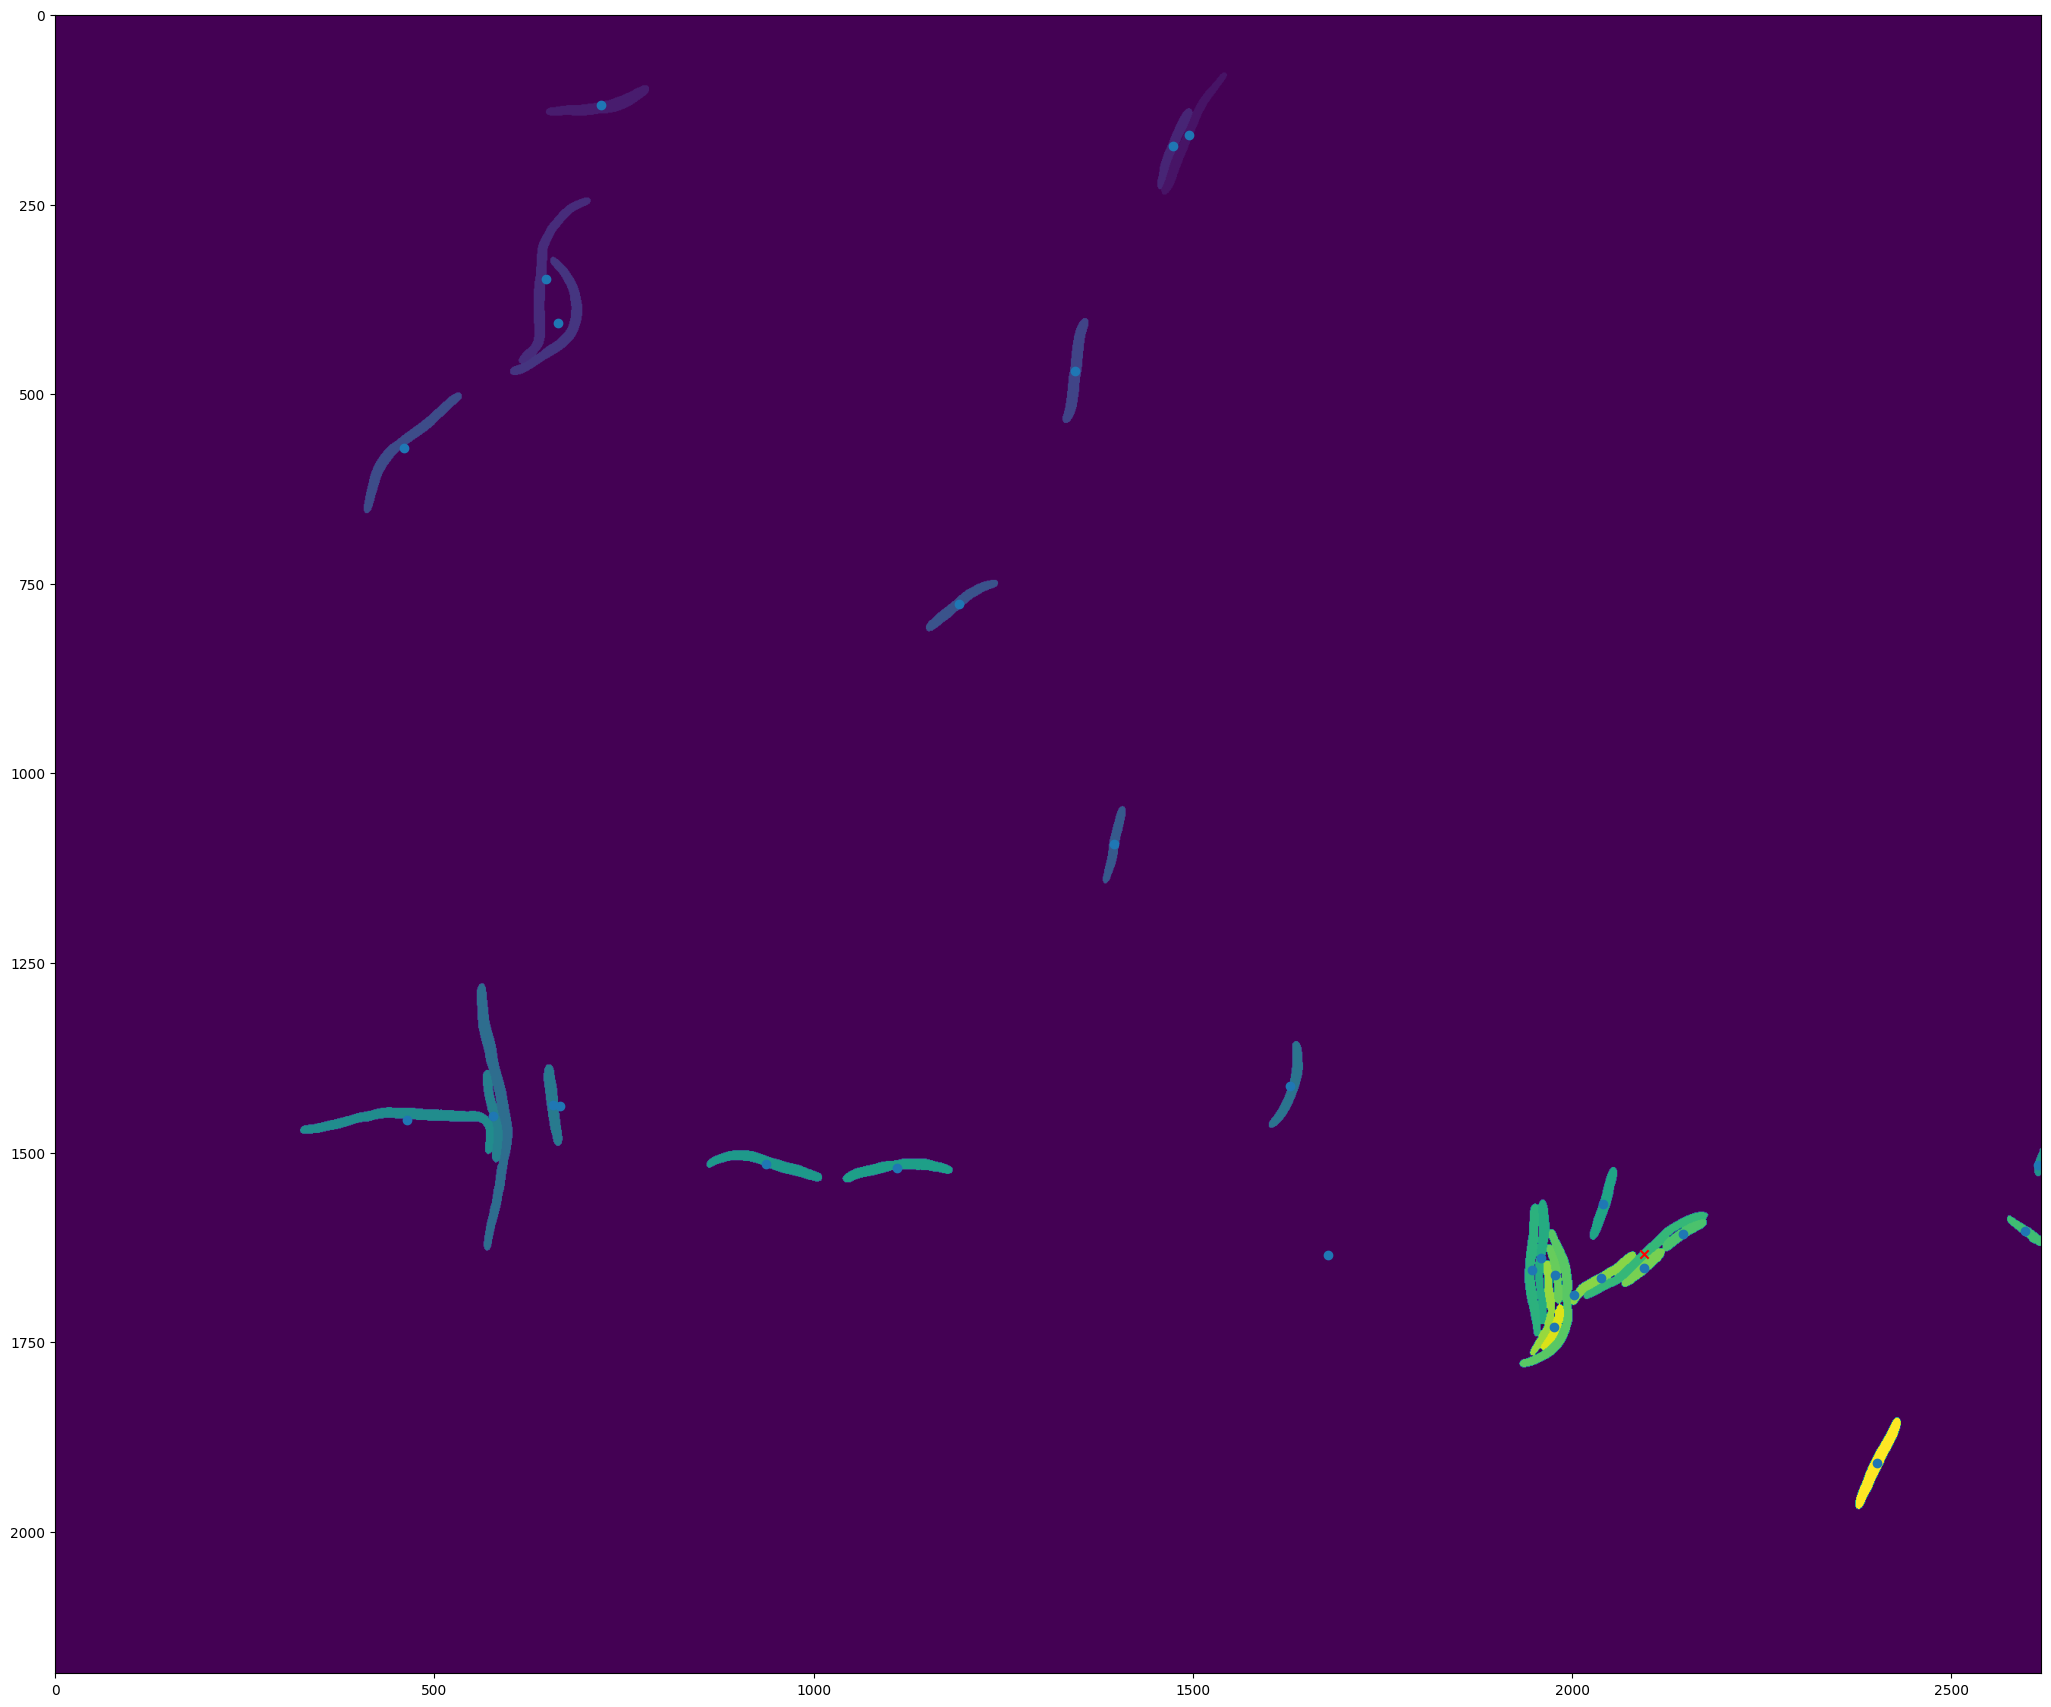

In [58]:
import matplotlib.pyplot as plt


npy_path = "/Users/sherryyang/Documents/wiggins-lab/data/0820/xy0/phase/211121_37C_10_1176_HU_timelapse002_prob211203_HU_t00004xy0c1_seg.npy"
dat = np.load(npy_path, allow_pickle=True).item()
gradientsx = np.gradient(dat['flows'][-1][0])
gradientsy = np.gradient(dat['flows'][-1][1])
gradient_total = gradientsy[1] + gradientsx[0]
regs_label = dat['masks']


plt.figure(figsize=(25.63, 21.87))
image = plt.imshow(regs_label)

plt.scatter(df['x_mean'], df['y_mean'])
plt.scatter([trackmate_x], [trackmate_y], color='red', marker='x', label='Marked Points')


In [55]:
np.max(regs_label)

43